In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-11-10 05:33:31.171008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 05:33:31.171106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 05:33:31.297085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths
train_img_path = "/kaggle/input/martianlunar-crater-detection-dataset/craters/train/images/"
train_lbl_path = "/kaggle/input/martianlunar-crater-detection-dataset/craters/train/labels/"
valid_img_path = "/kaggle/input/martianlunar-crater-detection-dataset/craters/valid/images/"
valid_lbl_path = "/kaggle/input/martianlunar-crater-detection-dataset/craters/valid/labels/"
test_img_path = "/kaggle/input/martianlunar-crater-detection-dataset/craters/test/images/"
test_lbl_path = "/kaggle/input/martianlunar-crater-detection-dataset/craters/test/labels/"

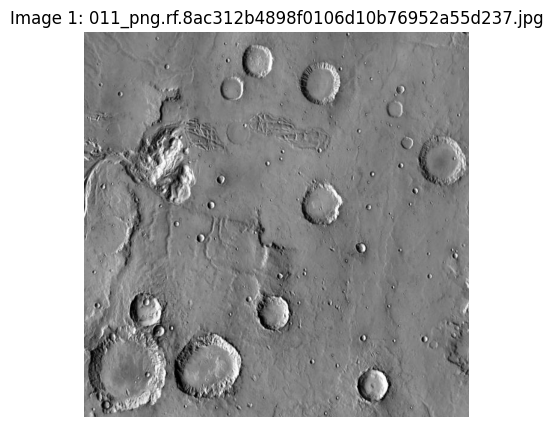

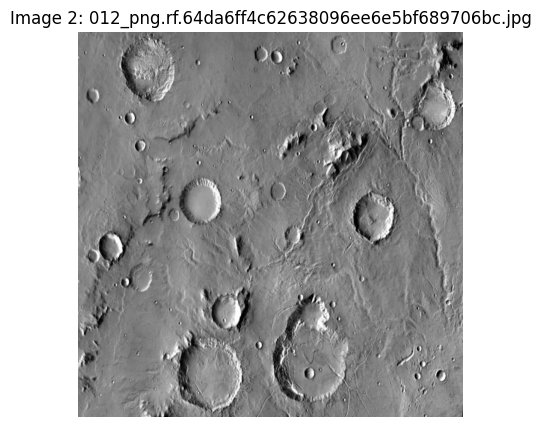

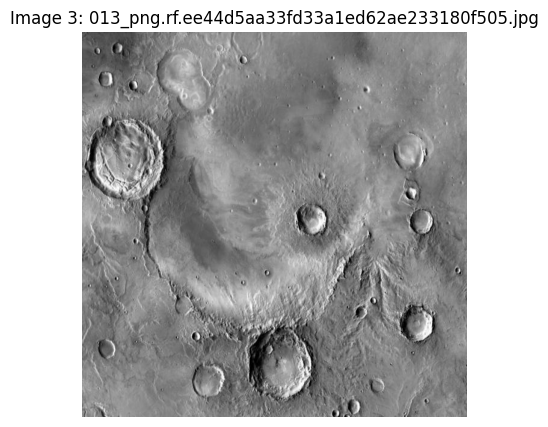

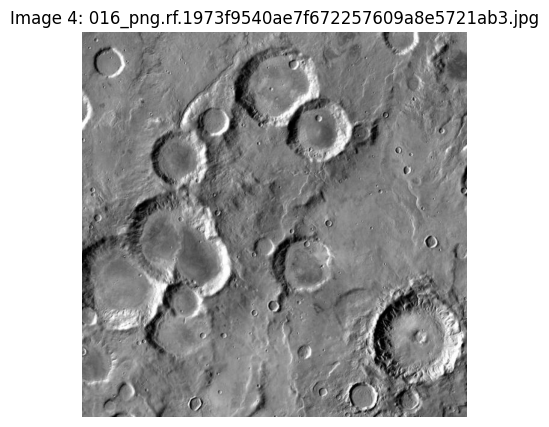

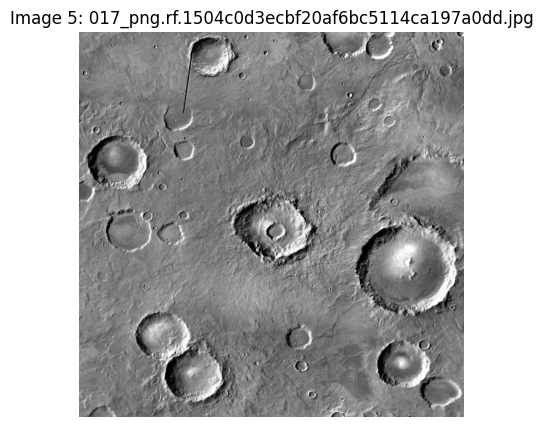

In [3]:
# Define the number of images to visualize
num_samples = 5  # Adjust this as needed

def visualize_images(image_dir, num_samples):
    image_files = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg') or fname.endswith('.png')])
    
    for i in range(min(num_samples, len(image_files))):
        img_path = image_files[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f'Image {i+1}: {os.path.basename(img_path)}')
        plt.axis('off')
        plt.show()

# Visualize images from the training directory
visualize_images(train_img_path, num_samples)

In [4]:
# Parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Adjust based on your images' resolution
BATCH_SIZE = 8
EPOCHS = 50
MODEL_SAVE_PATH = '/kaggle/working/unet_lunar_crater_segmentation.h5'

In [5]:
def load_images_and_masks(image_path, label_path, img_size=(128, 128)):
    """
    Load images and create binary masks from YOLO labels.
    """
    images = []
    masks = []
    
    image_files = os.listdir(image_path)
    for img_file in image_files:
        # Load the image
        img = load_img(os.path.join(image_path, img_file), target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)
        
        # Create an empty mask
        mask = np.zeros(img_size, dtype=np.uint8)
        
        # Read the corresponding label file
        label_file = os.path.join(label_path, img_file.replace('.jpg', '.txt'))
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                for line in f:
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    x1 = int((x_center - width / 2) * img_size[0])
                    y1 = int((y_center - height / 2) * img_size[1])
                    x2 = int((x_center + width / 2) * img_size[0])
                    y2 = int((y_center + height / 2) * img_size[1])
                    mask[y1:y2, x1:x2] = 1  # Mark the crater region
        
        masks.append(mask)
    
    return np.array(images), np.array(masks).reshape(-1, img_size[0], img_size[1], 1)

In [6]:
def build_unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = UpSampling2D((2, 2))(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = UpSampling2D((2, 2))(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs, outputs)
    return model

In [7]:
def train_model(model, train_images, train_masks, valid_images, valid_masks):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_images, train_masks,
        validation_data=(valid_images, valid_masks),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS
    )
    model.save(MODEL_SAVE_PATH)
    print("Model trained and saved successfully.")


In [8]:
def visualize_predictions(model, images, masks):
    predictions = model.predict(images)
    for i in range(3):  # Show three sample predictions
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[i])
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.show()


In [9]:
# Load training and validation data
train_images, train_masks = load_images_and_masks(train_img_path, train_lbl_path, (IMG_HEIGHT, IMG_WIDTH))
valid_images, valid_masks = load_images_and_masks(valid_img_path, valid_lbl_path, (IMG_HEIGHT, IMG_WIDTH))
    
# Build and compile UNet model
model = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
# Train the model
train_model(model, train_images, train_masks, valid_images, valid_masks)

Epoch 1/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 5:49 29s/step - accuracy: 0.0903 - loss: 0.6987

I0000 00:00:1731216855.203589     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6416 - loss: 0.6926 - val_accuracy: 0.7923 - val_loss: 0.6287
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8480 - loss: 0.4680 - val_accuracy: 0.7923 - val_loss: 0.5375
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8343 - loss: 0.4879 - val_accuracy: 0.7923 - val_loss: 0.5218
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8036 - loss: 0.5019 - val_accuracy: 0.7923 - val_loss: 0.5466
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7870 - loss: 0.5658 - val_accuracy: 0.7923 - val_loss: 0.5121
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7980 - loss: 0.5090 - val_accuracy: 0.7923 - val_loss: 0.5108
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8027 - loss: 0.5063 - val_accuracy: 0.7923 - val_loss: 0.5001
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8266 - loss: 0.4664 - val_accuracy: 0.7923 - val_loss: 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


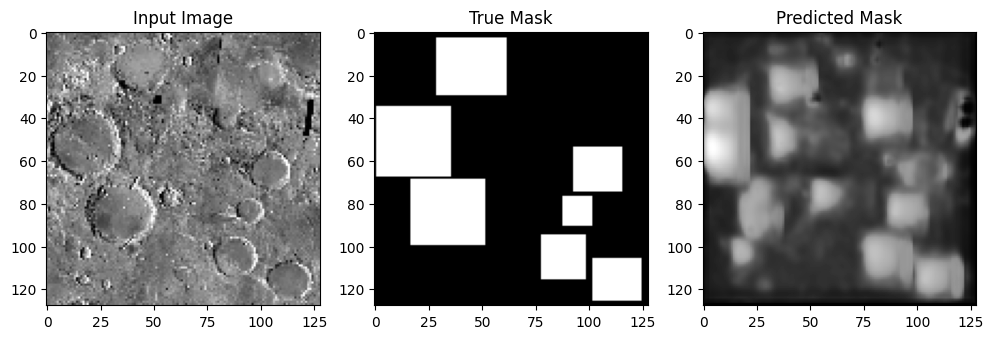

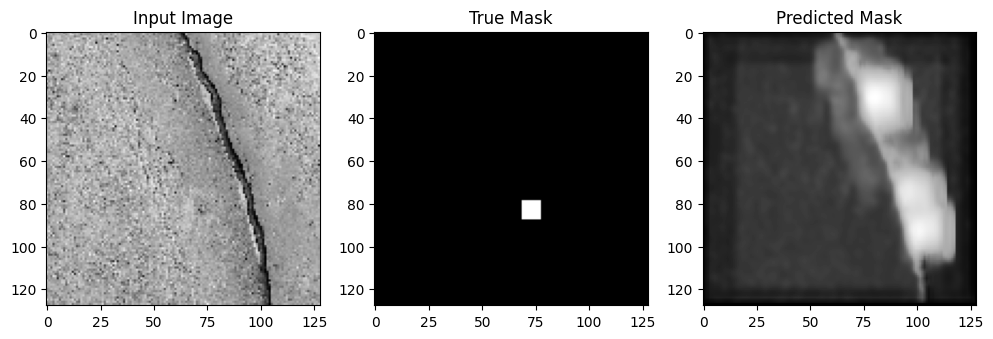

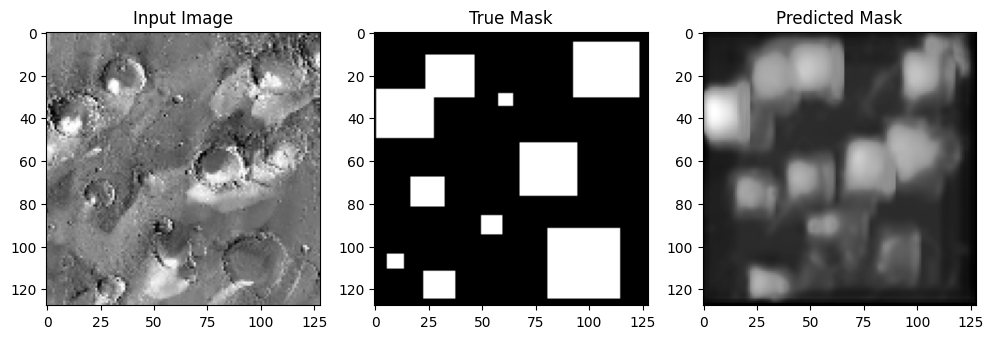

In [10]:
# Visualize predictions
visualize_predictions(model, valid_images[:3], valid_masks[:3])